In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

In [2]:
# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [3]:
# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [4]:
config = {
    # Model Architecture
    "input_channels": 64,
    "hidden_channels": 64,
    "gcn_out_channels": 32,
    "fc_out_channels": 1,
    "kernel_size": 5,

    # Loss Weights
    "alpha": 0.6,  # Pearson correlation weight
    "beta": 0.2,   # Cosine similarity weight
    "gamma": 0.1,
    "delta":0.1,

    # Training Parameters
    "learning_rate": 1e-3,
    "batch_size": 16,
    "epochs": 100,
    "use_subset_percentage": 1,

    # Logging
    "log_path": "tgn_eeg_log.csv",

    # Visualization
    "num_test_samples_plot": 5
}

In [5]:
class TGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, gcn_out_channels, fc_out_channels, kernel_size, adjacency):
        super(TGCN, self).__init__()
        self.adj = self.normalize_adjacency(adjacency)
        self.temporal_conv = nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.graph_weight = nn.Parameter(torch.Tensor(hidden_channels, gcn_out_channels))
        nn.init.xavier_uniform_(self.graph_weight)
        self.fc = nn.Linear(gcn_out_channels, fc_out_channels)

    def normalize_adjacency(self, A):
        A = A + torch.eye(A.size(0)).to(A.device)
        D_inv_sqrt = torch.diag(torch.pow(A.sum(1), -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt

    def forward(self, x):
        # x: (batch, time, channels)
        x = x.permute(0, 2, 1)  # → (batch, channels, time)
        x = self.temporal_conv(x)  # → (batch, hidden, time)

        x = x.permute(0, 2, 1)  # → (batch, time, hidden)
        A_hat = self.adj.to(x.device)  # shape: (channels, channels)

        x = x.permute(0, 2, 1)  # (batch, hidden, time)
        # Graph convolution with learned graph_weight and normalized adjacency
        x = torch.matmul(self.graph_weight.T @ A_hat, x)  # (out_channels, channels) @ (batch, channels, time)

        x = x.permute(0, 2, 1)  # (batch, time, out_channels)
        x = self.fc(x)  # → (batch, time, fc_out_channels)
        return x.squeeze(-1)  # → (batch, time)


In [6]:
def pearson_corr_loss(pred, target):
    vx = pred - torch.mean(pred, dim=1, keepdim=True)
    vy = target - torch.mean(target, dim=1, keepdim=True)
    corr = torch.sum(vx * vy, dim=1) / (torch.sqrt(torch.sum(vx**2, dim=1)) * torch.sqrt(torch.sum(vy**2, dim=1)) + 1e-8)
    return 1 - corr.mean()

def cosine_similarity_loss(pred, target):
    cos_sim = F.cosine_similarity(pred, target, dim=1)
    return 1 - cos_sim.mean()

def mse_loss(pred, target):
    return F.mse_loss(pred, target)

def mae_loss(pred, target):
    return F.l1_loss(pred, target)

def combined_loss(pred, target, alpha=0.3, beta=0.3, gamma=0.2, delta=0.2):
    # alpha, beta, gamma, delta are weights for each loss component
    # You can choose weights such that alpha + beta + gamma + delta = 1 (or not necessarily)
    return (alpha * pearson_corr_loss(pred, target) +
            beta * cosine_similarity_loss(pred, target) +
            gamma * mse_loss(pred, target) +
            delta * mae_loss(pred, target))

In [7]:
def get_adjacency_matrix(n_nodes):
    A = torch.eye(n_nodes)
    for i in range(n_nodes - 1):
        A[i, i+1] = A[i+1, i] = 1
    return A  # Simple chain-like structure; replace with real EEG layout if available

In [9]:
def train_model(model, optimizer, train_loader, val_loader, device, config):
    epochs = config["epochs"]
    log_path = config["log_path"]
    alpha = config["alpha"]
    beta = config["beta"]
    gamma = config["gamma"]
    delta = config["delta"]

    model = model.to(device)
    log = {
        "epoch": [],
        "train_loss": [], "train_pearson": [], "train_cosine": [],
        "val_loss": [], "val_pearson": [], "val_cosine": []
    }

    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_pearson, epoch_cos = 0, 0, 0

        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = combined_loss(pred, y, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_pearson += 1 - pearson_corr_loss(pred, y).item()
            epoch_cos += 1 - cosine_similarity_loss(pred, y).item()
            progress.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, val_pearson, val_cos = 0, 0, 0
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += combined_loss(pred, y, alpha=alpha, beta=beta, gamma=gamma, delta=delta).item()
                val_pearson += 1 - pearson_corr_loss(pred, y).item()
                val_cos += 1 - cosine_similarity_loss(pred, y).item()

        N_train = len(train_loader)
        N_val = len(val_loader)

        log["epoch"].append(epoch + 1)
        log["train_loss"].append(epoch_loss / N_train)
        log["train_pearson"].append(epoch_pearson / N_train)
        log["train_cosine"].append(epoch_cos / N_train)
        log["val_loss"].append(val_loss / N_val)
        log["val_pearson"].append(val_pearson / N_val)
        log["val_cosine"].append(val_cos / N_val)

        df = pd.DataFrame(log)
        df.to_csv(log_path, index=False)

    return model, log

In [11]:
def plot_train_val_curves(log, run_id):
    epochs = log['epoch']

    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Loss
    axs[0].plot(epochs, log['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(epochs, log['val_loss'], label='Val Loss', marker='s')
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Run {run_id}: Loss over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    # Pearson Correlation
    axs[1].plot(epochs, log['train_pearson'], label='Train Pearson', marker='o')
    axs[1].plot(epochs, log['val_pearson'], label='Val Pearson', marker='s')
    axs[1].set_ylabel("Pearson Corr")
    axs[1].set_title(f"Run {run_id}: Pearson Correlation over Epochs")
    axs[1].legend()
    axs[1].grid(True)

    # Cosine Similarity
    axs[2].plot(epochs, log['train_cosine'], label='Train Cosine', marker='o')
    axs[2].plot(epochs, log['val_cosine'], label='Val Cosine', marker='s')
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Cosine Similarity")
    axs[2].set_title(f"Run {run_id}: Cosine Similarity over Epochs")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


In [12]:
def plot_predictions(model, X_test, y_test, num_examples=5, run_id=1):
    model.eval()
    device = next(model.parameters()).device

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_pred = y_pred.cpu().numpy()
    y_true = y_test.cpu().numpy()

    for i in range(min(num_examples, len(y_true))):
        plt.figure(figsize=(10, 3))
        plt.plot(y_true[i], label='True Envelope', linewidth=2)
        plt.plot(y_pred[i], label='Predicted Envelope', linestyle='--')
        plt.title(f"Run {run_id}: Sample {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [13]:
configs = [
    {**config, "alpha": 0.6, "beta": 0.2, "gamma": 0.1, "delta": 0.1, "learning_rate": 1e-3, "batch_size": 16, "epochs": 50, "log_path": "tgn_eeg_log_run1.csv"},
    {**config, "alpha": 0.4, "beta": 0.4, "gamma": 0.1, "delta": 0.1, "learning_rate": 5e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run2.csv"},
    {**config, "alpha": 0.5, "beta": 0.3, "gamma": 0.1, "delta": 0.1, "learning_rate": 1e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run3.csv"},
    {**config, "alpha": 0.3, "beta": 0.5, "gamma": 0.1, "delta": 0.1, "learning_rate": 1e-3, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run4.csv"},
    {**config, "alpha": 0.7, "beta": 0.1, "gamma": 0.1, "delta": 0.1, "learning_rate": 5e-4, "batch_size": 16, "epochs": 50, "log_path": "tgn_eeg_log_run5.csv"},
    {**config, "alpha": 0.25, "beta": 0.55, "gamma": 0.1, "delta": 0.1, "learning_rate": 1e-3, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run6.csv"},
    {**config, "alpha": 0.5, "beta": 0.2, "gamma": 0.2, "delta": 0.1, "learning_rate": 3e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run7.csv"},
    {**config, "alpha": 0.3, "beta": 0.3, "gamma": 0.2, "delta": 0.2, "learning_rate": 2e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run8.csv"},
    {**config, "alpha": 0.4, "beta": 0.2, "gamma": 0.3, "delta": 0.1, "learning_rate": 1e-3, "batch_size": 16, "epochs": 50, "log_path": "tgn_eeg_log_run9.csv"},
    {**config, "alpha": 0.35, "beta": 0.35, "gamma": 0.15, "delta": 0.15, "learning_rate": 5e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run10.csv"},
    {**config, "alpha": 0.2, "beta": 0.6, "gamma": 0.1, "delta": 0.1, "learning_rate": 5e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run11.csv"},
    {**config, "alpha": 0.45, "beta": 0.25, "gamma": 0.2, "delta": 0.1, "learning_rate": 3e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run12.csv"},
    {**config, "alpha": 0.6, "beta": 0.1, "gamma": 0.2, "delta": 0.1, "learning_rate": 1e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run13.csv"},
    {**config, "alpha": 0.3, "beta": 0.4, "gamma": 0.2, "delta": 0.1, "learning_rate": 2e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run14.csv"},
    {**config, "alpha": 0.4, "beta": 0.3, "gamma": 0.2, "delta": 0.1, "learning_rate": 1e-3, "batch_size": 16, "epochs": 50, "log_path": "tgn_eeg_log_run15.csv"},
    {**config, "alpha": 0.5, "beta": 0.4, "gamma": 0.05, "delta": 0.05, "learning_rate": 1e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run16.csv"},
    {**config, "alpha": 0.55, "beta": 0.25, "gamma": 0.1, "delta": 0.1, "learning_rate": 3e-4, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run17.csv"},
    {**config, "alpha": 0.65, "beta": 0.15, "gamma": 0.1, "delta": 0.1, "learning_rate": 2e-4, "batch_size": 16, "epochs": 50, "log_path": "tgn_eeg_log_run18.csv"},
    {**config, "alpha": 0.35, "beta": 0.25, "gamma": 0.2, "delta": 0.2, "learning_rate": 5e-4, "batch_size": 64, "epochs": 50, "log_path": "tgn_eeg_log_run19.csv"},
    {**config, "alpha": 0.25, "beta": 0.25, "gamma": 0.25, "delta": 0.25, "learning_rate": 1e-3, "batch_size": 32, "epochs": 50, "log_path": "tgn_eeg_log_run20.csv"},
]

In [15]:
def run_training_runs(configs, X_train, y_train, X_val, y_val, X_test, y_test, get_adjacency_matrix, TGCN, train_model, plot_train_val_curves, plot_predictions):
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for i, cfg in enumerate(configs, 1):
        print(f"Training run {i} with config: {cfg}")

        N_train_subset = int(cfg["use_subset_percentage"] * X_train.shape[0])
        X_train_sub = X_train[:N_train_subset]
        y_train_sub = y_train[:N_train_subset]

        train_loader = DataLoader(TensorDataset(X_train_sub, y_train_sub), batch_size=cfg["batch_size"], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=cfg["batch_size"])

        A = get_adjacency_matrix(cfg["input_channels"])

        model = TGCN(
            in_channels=cfg["input_channels"],
            hidden_channels=cfg["hidden_channels"],
            gcn_out_channels=cfg["gcn_out_channels"],
            fc_out_channels=cfg["fc_out_channels"],
            kernel_size=cfg["kernel_size"],
            adjacency=A
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"])

        # Train model & get log
        trained_model, log = train_model(model, optimizer, train_loader, val_loader, device, cfg)

        # Plot training curves
        plot_train_val_curves(log, run_id=i)

        # Evaluate on test set
        trained_model.eval()
        with torch.no_grad():
            x_test = X_test.to(device)
            y_test_true = y_test.to(device)
            y_pred = trained_model(x_test)

            pearson = 1 - pearson_corr_loss(y_pred, y_test_true).item()
            cosine = 1 - cosine_similarity_loss(y_pred, y_test_true).item()

        print(f"Run {i} Test Pearson: {pearson:.4f}, Cosine: {cosine:.4f}")
        results.append({
            "config": cfg,
            "pearson": pearson,
            "cosine": cosine
        })

        # Plot predictions for a few samples
        plot_predictions(trained_model, X_test, y_test, num_examples=5, run_id=i)

        # Clean up to avoid memory issues
        del model, trained_model, optimizer, train_loader, val_loader, x_test, y_test_true, y_pred, log
        torch.cuda.empty_cache()

    return results

Training run 1 with config: {'input_channels': 64, 'hidden_channels': 64, 'gcn_out_channels': 32, 'fc_out_channels': 1, 'kernel_size': 5, 'alpha': 0.6, 'beta': 0.2, 'gamma': 0.1, 'delta': 0.1, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 50, 'use_subset_percentage': 1, 'log_path': 'tgn_eeg_log_run1.csv', 'num_test_samples_plot': 5}


Epoch 50/50: 100%|█████████████████████████████████████████████████████| 5712/5712 [00:32<00:00, 175.94it/s, loss=0.661]


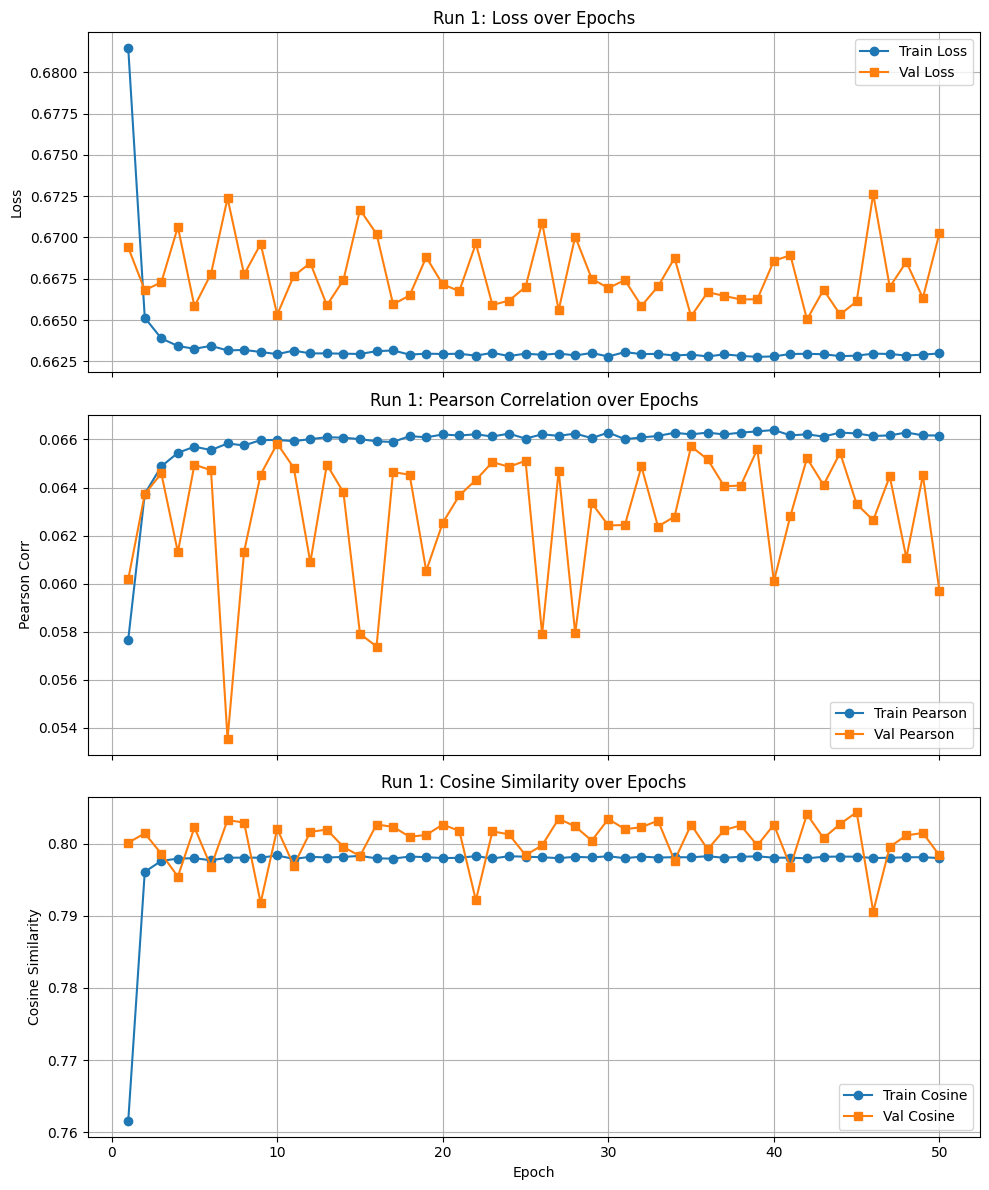

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.92 GiB. GPU 0 has a total capacity of 15.74 GiB of which 130.50 MiB is free. Process 20461 has 10.63 GiB memory in use. Including non-PyTorch memory, this process has 4.88 GiB memory in use. Of the allocated memory 3.92 GiB is allocated by PyTorch, and 7.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
results = run_training_runs(
    configs,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    get_adjacency_matrix,
    TGCN,
    train_model,
    plot_train_val_curves,
    plot_predictions
)

In [ ]:
import pandas as pd

summary_df = pd.DataFrame([{
    "run": i+1,
    "alpha": r["config"]["alpha"],
    "beta": r["config"]["beta"],
    "gamma": r["config"]["gamma"],
    "delta": r["config"]["delta"],
    "learning_rate": r["config"]["learning_rate"],
    "batch_size": r["config"]["batch_size"],
    "epochs": r["config"]["epochs"],
    "pearson": r["pearson"],
    "cosine": r["cosine"]
} for i, r in enumerate(results)])

print(summary_df)